In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
import tensorflow as tf

from tensorflow.keras import models, layers

2022-12-22 00:09:22.258534: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Accuracies")
    plt.show()
    plt.close()
    

def model_pretrained(learning_rate, pre_trained_model, opt='sgd'):

    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(224, 224, 3)))

    model.add(layers.Rescaling(1./127.5, offset=-1))

    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.2))

    model.add(pre_trained_model)

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    if opt == 'sgd':
        # opt = tf.keras.optimizers.SGD()
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    elif opt == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif opt == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Data preprocessing

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory('../dat/train/',
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       crop_to_aspect_ratio=True,
                                                       seed=42
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory('../dat/test/',
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     crop_to_aspect_ratio=True,
                                                     seed=42
                                                    )

test_ds = tf.keras.utils.image_dataset_from_directory('../dat/val/',
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     crop_to_aspect_ratio=True,
                                                     seed=42
                                                    )

Found 2816 files belonging to 2 classes.


2022-12-22 00:09:24.024775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 00:09:24.031908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 00:09:24.032562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 00:09:24.033465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Found 764 files belonging to 2 classes.
Found 412 files belonging to 2 classes.


 NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 00:09:24.657400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13795 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


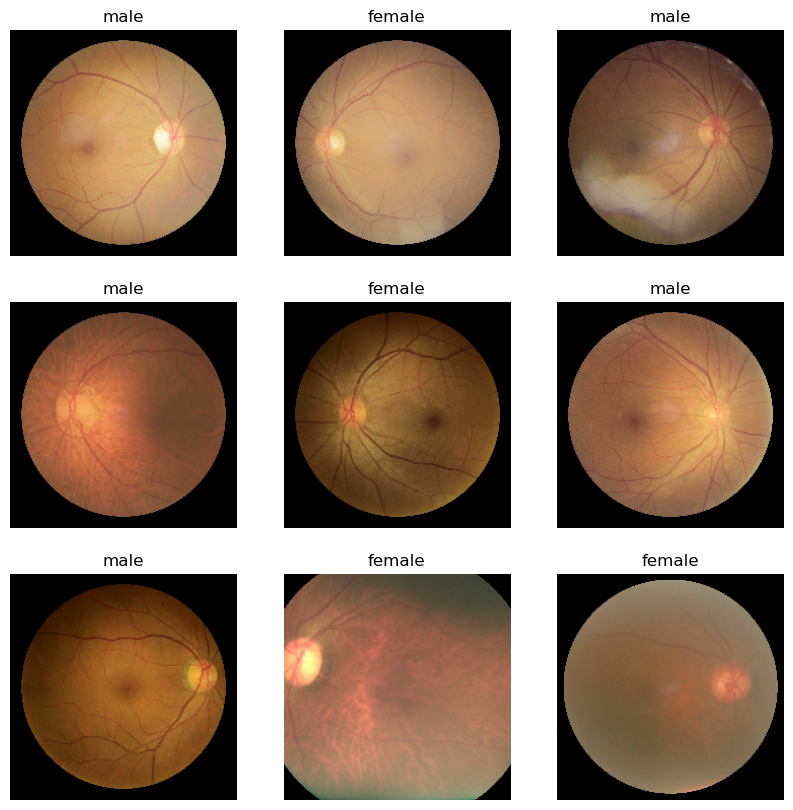

In [4]:
# Visualize some images from the training set
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Using pre-trained models

In [6]:
# Create the base model from the pre-trained models
IMG_SHAPE = IMG_SIZE + (3,)


base_model_mobilenet = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                         include_top=False,
                                                         weights='imagenet')
base_model_mobilenet.trainable = False


# base_model_xception = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
#                                                     include_top=False, 
#                                                     weights='imagenet')
# base_model_xception.trainable = False


#base_model_inception = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
#                                                         include_top=False,
#                                                         weights='imagenet')
# base_model_inception.trainable = False

In [7]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(224, 224, 3)))

model.add(layers.Rescaling(1./127.5, offset=-1))
model.add(layers.RandomFlip("horizontal"))
model.add(layers.RandomRotation(0.2))

model.add(base_model_mobilenet)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                        

In [9]:
# adaptable learning rate
# lr_sched = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-2 * (0.80 ** np.floor(epoch / 2)))
lr = 0.005

# opt = tf.keras.optimizers.SGD()
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.8)
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)    

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [10]:
len(model.trainable_variables)

2

### Train the model

In [11]:
# initial_epochs = 100
loss0, accuracy0 = model.evaluate(val_ds)

2022-12-22 00:09:33.617575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-22 00:09:34.251310: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 00:09:34.252188: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 00:09:34.252246: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-22 00:09:34.253105: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 00:09:34.253180: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


24/24 [==============================] - 10s 186ms/step - loss: 0.8653 - accuracy: 0.4332


In [12]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.43


In [13]:
history_list = {}

In [14]:
initial_epochs = 100

history = model.fit(
    train_ds,
    batch_size=20,
    epochs=initial_epochs,
    validation_data=val_ds
)

history_list['model_1'] = history.history

Epoch 1/100
88/88 [==============================] - 33s 321ms/step - loss: 0.7509 - accuracy: 0.5284 - val_loss: 0.7218 - val_accuracy: 0.5249
Epoch 2/100
88/88 [==============================] - 30s 322ms/step - loss: 0.7148 - accuracy: 0.5423 - val_loss: 0.7339 - val_accuracy: 0.5628
Epoch 3/100
88/88 [==============================] - 30s 321ms/step - loss: 0.7010 - accuracy: 0.5568 - val_loss: 0.6929 - val_accuracy: 0.5576
Epoch 4/100
88/88 [==============================] - 30s 323ms/step - loss: 0.6927 - accuracy: 0.5664 - val_loss: 0.7068 - val_accuracy: 0.5471
Epoch 5/100
88/88 [==============================] - 30s 323ms/step - loss: 0.7138 - accuracy: 0.5518 - val_loss: 0.7317 - val_accuracy: 0.5694
Epoch 6/100
88/88 [==============================] - 31s 326ms/step - loss: 0.6797 - accuracy: 0.5874 - val_loss: 0.6820 - val_accuracy: 0.5877
Epoch 7/100
88/88 [==============================] - 30s 321ms/step - loss: 0.6769 - accuracy: 0.5874 - val_loss: 0.6889 - val_accuracy:

### Learning curves

In [15]:
# render_history(history.history)

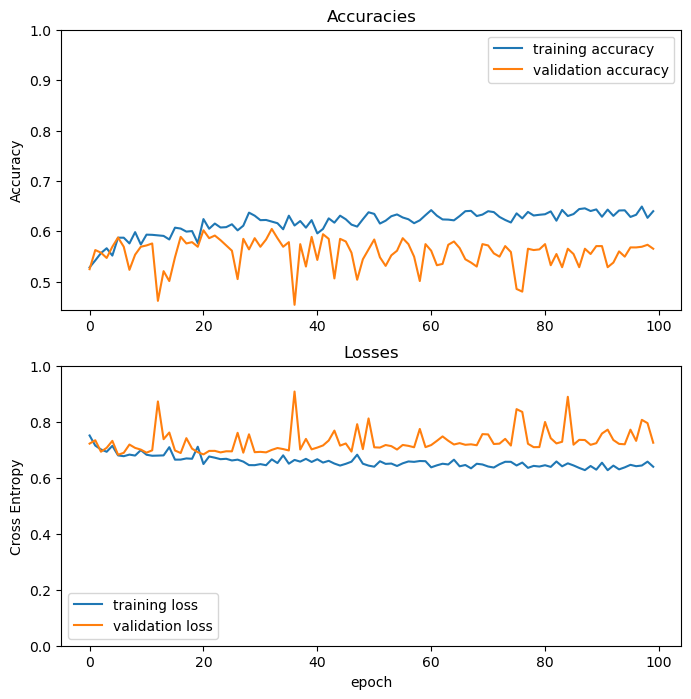

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracies')

plt.subplot(2, 1, 2)
plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Losses')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [17]:
base_model_mobilenet.trainable = True
# base_model_xception.trainable = True
# base_model_inception.trainable = True

In [19]:
# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model_mobilenet.layers))
# print("Number of layers in the base model: ", len(base_model_xception.layers))
# print("Number of layers in the base model: ", len(base_model_inception.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_mobilenet.layers[:fine_tune_at]:
# for layer in base_model_xception.layers[:fine_tune_at]:
# for layer in base_model_inception.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [20]:
# opt = tf.keras.optimizers.SGD()
# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.8)
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
opt = tf.keras.optimizers.RMSprop(learning_rate=lr/10)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)    

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                        

In [22]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [24]:
fine_tune_epochs = 300
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 100/400
88/88 [==============================] - 36s 331ms/step - loss: 0.9379 - accuracy: 0.5256 - val_loss: 1.3228 - val_accuracy: 0.5471
Epoch 101/400
88/88 [==============================] - 31s 329ms/step - loss: 0.7113 - accuracy: 0.5401 - val_loss: 0.9592 - val_accuracy: 0.5576
Epoch 102/400
88/88 [==============================] - 31s 326ms/step - loss: 0.6966 - accuracy: 0.5600 - val_loss: 0.8819 - val_accuracy: 0.4490
Epoch 103/400
88/88 [==============================] - 31s 326ms/step - loss: 0.6865 - accuracy: 0.5632 - val_loss: 1.3546 - val_accuracy: 0.5576
Epoch 104/400
88/88 [==============================] - 31s 330ms/step - loss: 0.6772 - accuracy: 0.5856 - val_loss: 0.7126 - val_accuracy: 0.5746
Epoch 105/400
88/88 [==============================] - 31s 333ms/step - loss: 0.6522 - accuracy: 0.6140 - val_loss: 1.0118 - val_accuracy: 0.5576
Epoch 106/400
88/88 [==============================] - 31s 330ms/step - loss: 0.6449 - accuracy: 0.6268 - val_loss: 2.3709 -

In [25]:
# render_history(history_fine.history)

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

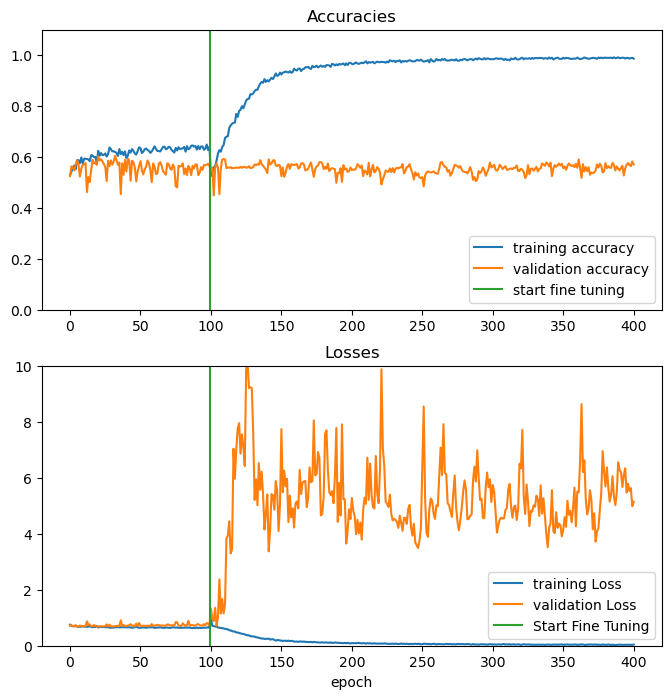

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.ylim([0, 1.1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='start fine tuning')
plt.legend(loc='best')
plt.title('Accuracies')

plt.subplot(2, 1, 2)
plt.plot(loss, label='training Loss')
plt.plot(val_loss, label='validation Loss')
plt.ylim([0, 10])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Losses')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [42]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

13/13 [==============================] - 4s 107ms/step - loss: 5.5212 - accuracy: 0.5752
Test accuracy : 0.5752426981925964


And now you are all set to use this model to predict if your pet is a cat or dog.

In [45]:
model.save("mobilenetv2_retina_400_057_v1.h5")